# 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_path='/content/drive/MyDrive/AI_data/프로젝트/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

# 필요한 패키지 불러오기

In [88]:
import numpy as np # 배열 프로세싱
import pandas as pd # 데이터 프레임 프로세싱
import matplotlib.pyplot as plt # 시각화 모듈
import seaborn as sns # 상관계수 시각화

# 머신러닝에 사용할 모듈
from sklearn.model_selection import train_test_split # train set과 test set을 나누어 주는 패키지
from sklearn.metrics import confusion_matrix # confusion matrix 확인
from sklearn.preprocessing import StandardScaler # 스케일링
from sklearn.svm import SVC # SVM 지도학습을 시키기 위한 모듈
from sklearn.ensemble import RandomForestClassifier # RandomForest 지도학습을 시키기 위한 모듈
from imblearn.over_sampling import SMOTE

# 한글 폰트 사용을 위한 코드

In [3]:
# 한글폰트 사용 in colab
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


# DPpia 크롤링

구글코랩에서는 크롬드라이버가 제대로 작동하지 않아 크롤링 파트만 주피터 노트북을 사용하였습니다. 크롤링 파트를 제외한 나머지 코드는 모두 구글코랩에서 문제없이 정상 작동함을 확인하였습니다.  
=> 이에 DBpia 크롤링 과정만 포함된 jupyter 코드 파일을 추가로 첨부하였습니다. (파일명:"DBpia_크롤링코드_서영광.ipynb")

In [4]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 31.6 MB/s 
     |████████████████████████████████| 140 kB 98.4 MB/s 
     |████████████████████████████████| 384 kB 52.4 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 https://cloud.r-project.org

In [15]:
from selenium import webdriver # 웹서버에 데이터 요청하는 라이브러리
from selenium.webdriver.common.keys import Keys # 키보드의 키를 컴퓨터에 전달하기 위해 사용
import time # 시간을 재는 라이브러리
from tqdm.notebook import tqdm # 크롤링 프로그레스를 출력시켜주는 라이브러리
import pandas as pd

import urllib.request
import urllib.parse
from bs4 import BeautifulSoup

In [17]:
# dbpia 주소를 url에 저장
url = 'https://www.dbpia.co.kr/'
# 크롬 창 띄우기(Colab에선 웹브라우저 창이 뜨지 않으므로 별도 설정한다.)
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver=webdriver.Chrome('chromedriver', options=options)
# url 변수에 저장한 사이트 주소로 들어가기
driver.get(url)

search_area = driver.find_element("xpath", '//*[@id="keyword"]') # 검색창
search_area.send_keys('당뇨병') # 검색어 '당뇨병' 입력
driver.find_element("xpath", '//*[@id="searchWrapper"]/div[1]/a').send_keys(Keys.ENTER) # ENTER로 검색

In [18]:
def paper_title_print(paper_df):
    time.sleep(2) # 2초씩 쉬어주기
    
    html = driver.page_source # html 페이지 읽기
    soup = BeautifulSoup(html, 'html.parser')
    
    # 한 페이지에 나오는 논문 20개의 제목을 읽고 title_list에 append
    title_list = []
    for i in range(20):
        title_list.append(soup.find_all('h2','thesis__tit')[i].text)
        
    # title_list를 데이터프레임에 담기
    dic = dict(list(zip(list(range(len(paper_df),len(paper_df)+20)), title_list))) # 인덱스, 제목 리스트를 딕셔너리로 묶기
    for key,value in dic.items():
        paper_df.loc[key] = value # 데이터 프레임에 저장

In [19]:
# 데이터프레임 생성
paper_df = pd.DataFrame(columns=['제목'])

page = 1
page_2 = 0

# 한 페이지에 나오는 항목 개수 20개 -> 총 400개를 읽기 위해 20번 클릭
total_clicks = 20
next = False

# 10페이지까지 출력
for click in tqdm(range(total_clicks)):
    try:
        page_2 += 1
        print("-------------", page, "-------------")
        if next == False:
            driver.find_element("xpath", f'//*[@id="pageList"]/a[{page_2}]').send_keys(Keys.ENTER)
        paper_title_print(paper_df)
        next = False
        
        # 10번째 페이지가 되면 next 버튼을 누르기
        if (page_2)%10 == 0:
            driver.find_element("xpath", '//*[@id="goNextPage"]').send_keys(Keys.ENTER)
            page_2 = 0
            next = True
        page += 1
        
    except:
        break
        
print("크롤링 완료")

  0%|          | 0/20 [00:00<?, ?it/s]

------------- 1 -------------
크롤링 완료


In [20]:
paper_df

,제목


In [ ]:
# 데이터프레임을 csv파일로 저장
paper_df.to_csv('diabetes_paper.csv')

# 당뇨병 관련 논문 제목 형태소 분석

In [21]:
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev
!pip3 install JPype1-py3
!pip3 install konlpy
!JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net/deadsnake

In [27]:
data_path='/content/drive/MyDrive/AI_data/프로젝트/'
paper_df = pd.read_csv(data_path+'diabetes_paper.csv')
paper_df.drop(['Unnamed: 0'], axis=1, inplace=True)
paper_df

,제목
0,국내 중년 여성의 제2형 당뇨병과 우울(PHQ-9)의 관계
1,이론을 적용한 당뇨병환자 대상 국내 연구의 동향: 주제범위 문헌고찰
2,"간호대학생의 당뇨병 방문건강관리 관련 지식, 자기효능감, 문제해결과정이 임상수행 능..."
3,토픽 모델링을 통한 COVID-19 팬데믹 시기의 당뇨병 환자 관련 뉴스 키워드 분석
4,딥러닝 이미지 분석을 통한 당뇨병 환자 식이요법 서포팅 서비스 개발
...,...
395,필터링기법을 이용한 당뇨병 예측의 정확도 향상방법
396,타이치 운동프로그램이 당뇨병환자의 대사조절 및 삶의 질에 미치는 효과
397,전당뇨병 대상자의 유제품 및 어패류 섭취와 대사증후군 위험인자와의 관련성 연구 : ...
398,"당뇨병 환자의 자가관리, 우울 양상이 양생에 미치는 영향"


In [30]:
# 한글 텍스트 분석을 위해 konlpy 모듈 import
from konlpy.tag import Komoran
tagger=Komoran()

In [31]:
token_nouns=[tagger.nouns(d) for d in paper_df['제목']]
paper_df['명사']=token_nouns
paper_df

,제목,명사
0,국내 중년 여성의 제2형 당뇨병과 우울(PHQ-9)의 관계,"[국내, 중년, 여성, 당뇨병, 우울, 관계]"
1,이론을 적용한 당뇨병환자 대상 국내 연구의 동향: 주제범위 문헌고찰,"[이론, 적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 주제, 범위, 문헌, 고찰]"
2,"간호대학생의 당뇨병 방문건강관리 관련 지식, 자기효능감, 문제해결과정이 임상수행 능...","[간호, 대학생, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 감, 문제, 해결..."
3,토픽 모델링을 통한 COVID-19 팬데믹 시기의 당뇨병 환자 관련 뉴스 키워드 분석,"[토픽, 모델링, 팬데믹, 시기, 당뇨병, 환자, 관련, 뉴스, 키워드, 분석]"
4,딥러닝 이미지 분석을 통한 당뇨병 환자 식이요법 서포팅 서비스 개발,"[이미지, 분석, 당뇨병, 환자, 식이요법, 서비스, 개발]"
...,...,...
395,필터링기법을 이용한 당뇨병 예측의 정확도 향상방법,"[필터링, 기법, 이용한, 당뇨병, 예측, 정확도, 향상, 방법]"
396,타이치 운동프로그램이 당뇨병환자의 대사조절 및 삶의 질에 미치는 효과,"[이치, 운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]"
397,전당뇨병 대상자의 유제품 및 어패류 섭취와 대사증후군 위험인자와의 관련성 연구 : ...,"[당뇨병, 대상자, 유제품, 어패, 섭취, 대사, 증후군, 위험, 자와, 관련성, ..."
398,"당뇨병 환자의 자가관리, 우울 양상이 양생에 미치는 영향","[당뇨병, 환자, 자가, 관리, 우울, 양상, 양생, 영향]"


In [ ]:
import nltk # 영어 자연어처리에 특화된 모듈인 nltk 임포트
bglist = []
# 단어의 리스트를 넣어서 바이그램 리스트를 받는다. 이를 모두 더해서 하나의 큰 리스트로 만든다.
for sentence in paper_df["명사"]:
    bglist += nltk.bigrams(sentence)
bglist

In [ ]:
from collections import Counter # sequence data에서 원소의 빈도수를 세는 일반 모듈
bgCountDict = Counter(bglist)
bgCountDict

In [36]:
bgCountDict.most_common(100)

[(('당뇨병', '환자'), 170),
 (('국민', '건강'), 31),
 (('건강', '영양'), 31),
 (('영양', '조사'), 31),
 (('당뇨병', '노인'), 26),
 (('고혈압', '당뇨병'), 24),
 (('영향', '요인'), 21),
 (('관련', '요인'), 18),
 (('조사', '자료'), 16),
 (('혈당', '조절'), 16),
 (('노인', '당뇨병'), 16),
 (('자가', '관리'), 15),
 (('자가', '간호'), 14),
 (('자료', '이용'), 14),
 (('문헌', '고찰'), 12),
 (('복합', '운동'), 12),
 (('효능', '감'), 11),
 (('이용한', '당뇨병'), 11),
 (('전', '단계'), 11),
 (('한국', '성인'), 11),
 (('운동', '당뇨병'), 11),
 (('당뇨병', '발생'), 10),
 (('당뇨병', '유병'), 10),
 (('간호', '행위'), 10),
 (('병', '증'), 10),
 (('성인', '당뇨병'), 10),
 (('기', '국민'), 10),
 (('체계', '문헌'), 9),
 (('지역', '사회'), 9),
 (('신경', '병'), 9),
 (('신체', '활동'), 9),
 (('환자', '혈당'), 9),
 (('당뇨병', '전'), 8),
 (('환자', '건강'), 8),
 (('매개', '효과'), 8),
 (('코', '호'), 8),
 (('환자', '자가'), 8),
 (('노인', '여성'), 8),
 (('환자', '당뇨병'), 7),
 (('임신', '당뇨병'), 7),
 (('여성', '노인'), 7),
 (('주간', '복합'), 7),
 (('인슐린', '저항'), 7),
 (('당뇨병', '자가'), 6),
 (('건강', '행태'), 6),
 (('당뇨병', '마우스'), 6),
 (('당뇨병', '예측'), 6),
 (('당뇨병', '여성'), 6),
 

In [44]:
# 사용자 사전 txt 파일을 읽어오기
with open(data_path+'user_dic.txt', encoding='UTF8') as f:
    for line in f.readlines():
        print(line.replace('\t', '<TAB>'))

효능감<TAB>NNG

병증<TAB>NNG

자기관리<TAB>NNG

전 단계<TAB>NNG

건강관리<TAB>NNG


=> 결과에 큰 영향을 미칠 수 있는 단어는 찾지 못했음 (사용자 사전 만든 의미가 크게 없음)

In [45]:
tagger = Komoran(userdic=data_path+'user_dic.txt')
token_nouns=[tagger.nouns(d) for d in paper_df['제목']]
paper_df['복합명사 포함']=token_nouns
paper_df

,제목,명사,복합명사 포함
0,국내 중년 여성의 제2형 당뇨병과 우울(PHQ-9)의 관계,"[국내, 중년, 여성, 당뇨병, 우울, 관계]","[국내, 중년, 여성, 당뇨병, 우울, 관계]"
1,이론을 적용한 당뇨병환자 대상 국내 연구의 동향: 주제범위 문헌고찰,"[이론, 적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 주제, 범위, 문헌, 고찰]","[이론, 적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 주제, 범위, 문헌, 고찰]"
2,"간호대학생의 당뇨병 방문건강관리 관련 지식, 자기효능감, 문제해결과정이 임상수행 능...","[간호, 대학생, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 감, 문제, 해결...","[간호, 대학생, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 감, 문제, 해결..."
3,토픽 모델링을 통한 COVID-19 팬데믹 시기의 당뇨병 환자 관련 뉴스 키워드 분석,"[토픽, 모델링, 팬데믹, 시기, 당뇨병, 환자, 관련, 뉴스, 키워드, 분석]","[토픽, 모델링, 팬데믹, 시기, 당뇨병, 환자, 관련, 뉴스, 키워드, 분석]"
4,딥러닝 이미지 분석을 통한 당뇨병 환자 식이요법 서포팅 서비스 개발,"[이미지, 분석, 당뇨병, 환자, 식이요법, 서비스, 개발]","[이미지, 분석, 당뇨병, 환자, 식이요법, 서비스, 개발]"
...,...,...,...
395,필터링기법을 이용한 당뇨병 예측의 정확도 향상방법,"[필터링, 기법, 이용한, 당뇨병, 예측, 정확도, 향상, 방법]","[필터링, 기법, 이용한, 당뇨병, 예측, 정확도, 향상, 방법]"
396,타이치 운동프로그램이 당뇨병환자의 대사조절 및 삶의 질에 미치는 효과,"[이치, 운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]","[이치, 운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]"
397,전당뇨병 대상자의 유제품 및 어패류 섭취와 대사증후군 위험인자와의 관련성 연구 : ...,"[당뇨병, 대상자, 유제품, 어패, 섭취, 대사, 증후군, 위험, 자와, 관련성, ...","[당뇨병, 대상자, 유제품, 어패, 섭취, 대사, 증후군, 위험, 자와, 관련성, ..."
398,"당뇨병 환자의 자가관리, 우울 양상이 양생에 미치는 영향","[당뇨병, 환자, 자가, 관리, 우울, 양상, 양생, 영향]","[당뇨병, 환자, 자가, 관리, 우울, 양상, 양생, 영향]"


In [46]:
# 복합어 토큰 안의 모든 단어를 하나의 리스트 안에 넣기
token_all_one = [t for tlist in paper_df['복합명사 포함'] for t in tlist]

In [47]:
# 빈도수를 세어서 내림차순으로 정렬
countDict = Counter(token_all_one)
sortedCountList = sorted(countDict.items(), key=operator.itemgetter(1), reverse=True)
# 내림차순으로 정렬된 리스트에서 상위 200개만 출력
sortedCountList[:200]

[('당뇨병', 424),
 ('환자', 206),
 ('영향', 92),
 ('관리', 67),
 ('건강', 63),
 ('효과', 58),
 ('요인', 55),
 ('노인', 52),
 ('혈당', 49),
 ('연구', 48),
 ('영양', 47),
 ('분석', 44),
 ('관련', 38),
 ('조사', 35),
 ('자가', 33),
 ('자료', 32),
 ('성인', 32),
 ('고혈압', 32),
 ('국민', 31),
 ('당뇨', 27),
 ('조절', 27),
 ('이용한', 26),
 ('운동', 26),
 ('위험', 24),
 ('치료', 24),
 ('발생', 24),
 ('이용', 24),
 ('중심', 23),
 ('여성', 22),
 ('프로그램', 22),
 ('관련성', 22),
 ('기반', 21),
 ('질환', 21),
 ('한국', 20),
 ('기', 20),
 ('사회', 20),
 ('연관', 20),
 ('간호', 19),
 ('행위', 19),
 ('관계', 18),
 ('증', 18),
 ('교육', 18),
 ('우울', 17),
 ('고찰', 17),
 ('예측', 17),
 ('병', 17),
 ('삶의 질', 17),
 ('당화혈색소', 16),
 ('비교', 16),
 ('지표', 16),
 ('수준', 16),
 ('효능', 15),
 ('유병', 15),
 ('인슐린', 15),
 ('지식', 14),
 ('개발', 14),
 ('단계', 14),
 ('지역', 14),
 ('간', 14),
 ('변화', 14),
 ('활용', 14),
 ('진단', 14),
 ('예방', 14),
 ('신체', 14),
 ('모델', 14),
 ('복합', 14),
 ('문헌', 13),
 ('감', 13),
 ('대사', 13),
 ('신경', 13),
 ('대상', 12),
 ('섭취', 12),
 ('합병증', 12),
 ('중', 12),
 ('경험', 12),
 ('심혈관', 12),
 (

In [61]:
# 불용어를 선택하여 제외시킨 리스트를 만든 뒤 '불용어 제외' 컬럼에 추가
stop_words=['기','증','이용한','감','중','전','후','혈','코','호','안','력','세','년','식','발','체','자',
            '지지','족','부','수','유','악','이','형']
token_final=[]
for doc in paper_df['복합명사 포함']:
    wordslist = [w for w in doc if w not in stop_words]
    token_final.append(wordslist)

paper_df['불용어 제외']=token_final
paper_df

,제목,명사,복합명사 포함,불용어 제외
0,국내 중년 여성의 제2형 당뇨병과 우울(PHQ-9)의 관계,"[국내, 중년, 여성, 당뇨병, 우울, 관계]","[국내, 중년, 여성, 당뇨병, 우울, 관계]","[국내, 중년, 여성, 당뇨병, 우울, 관계]"
1,이론을 적용한 당뇨병환자 대상 국내 연구의 동향: 주제범위 문헌고찰,"[이론, 적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 주제, 범위, 문헌, 고찰]","[이론, 적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 주제, 범위, 문헌, 고찰]","[이론, 적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 주제, 범위, 문헌, 고찰]"
2,"간호대학생의 당뇨병 방문건강관리 관련 지식, 자기효능감, 문제해결과정이 임상수행 능...","[간호, 대학생, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 감, 문제, 해결...","[간호, 대학생, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 감, 문제, 해결...","[간호, 대학생, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 문제, 해결, 과..."
3,토픽 모델링을 통한 COVID-19 팬데믹 시기의 당뇨병 환자 관련 뉴스 키워드 분석,"[토픽, 모델링, 팬데믹, 시기, 당뇨병, 환자, 관련, 뉴스, 키워드, 분석]","[토픽, 모델링, 팬데믹, 시기, 당뇨병, 환자, 관련, 뉴스, 키워드, 분석]","[토픽, 모델링, 팬데믹, 시기, 당뇨병, 환자, 관련, 뉴스, 키워드, 분석]"
4,딥러닝 이미지 분석을 통한 당뇨병 환자 식이요법 서포팅 서비스 개발,"[이미지, 분석, 당뇨병, 환자, 식이요법, 서비스, 개발]","[이미지, 분석, 당뇨병, 환자, 식이요법, 서비스, 개발]","[이미지, 분석, 당뇨병, 환자, 식이요법, 서비스, 개발]"
...,...,...,...,...
395,필터링기법을 이용한 당뇨병 예측의 정확도 향상방법,"[필터링, 기법, 이용한, 당뇨병, 예측, 정확도, 향상, 방법]","[필터링, 기법, 이용한, 당뇨병, 예측, 정확도, 향상, 방법]","[필터링, 기법, 당뇨병, 예측, 정확도, 향상, 방법]"
396,타이치 운동프로그램이 당뇨병환자의 대사조절 및 삶의 질에 미치는 효과,"[이치, 운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]","[이치, 운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]","[이치, 운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]"
397,전당뇨병 대상자의 유제품 및 어패류 섭취와 대사증후군 위험인자와의 관련성 연구 : ...,"[당뇨병, 대상자, 유제품, 어패, 섭취, 대사, 증후군, 위험, 자와, 관련성, ...","[당뇨병, 대상자, 유제품, 어패, 섭취, 대사, 증후군, 위험, 자와, 관련성, ...","[당뇨병, 대상자, 유제품, 어패, 섭취, 대사, 증후군, 위험, 자와, 관련성, ..."
398,"당뇨병 환자의 자가관리, 우울 양상이 양생에 미치는 영향","[당뇨병, 환자, 자가, 관리, 우울, 양상, 양생, 영향]","[당뇨병, 환자, 자가, 관리, 우울, 양상, 양생, 영향]","[당뇨병, 환자, 자가, 관리, 우울, 양상, 양생, 영향]"


In [62]:
# pickle을 이용하여 파일로 저장
import pickle
with open(data_path+'diabetes_paper_tokens.dump', 'wb') as f:
    pickle.dump(paper_df, f)

In [4]:
# 저장한 파일 읽어들이기
import pickle
with open(data_path+'diabetes_paper_tokens.dump', 'rb') as f:
    paper_df=pickle.load(f)
paper_df

,제목,명사,복합명사 포함,불용어 제외
0,국내 중년 여성의 제2형 당뇨병과 우울(PHQ-9)의 관계,"[국내, 중년, 여성, 당뇨병, 우울, 관계]","[국내, 중년, 여성, 당뇨병, 우울, 관계]","[국내, 중년, 여성, 당뇨병, 우울, 관계]"
1,이론을 적용한 당뇨병환자 대상 국내 연구의 동향: 주제범위 문헌고찰,"[이론, 적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 주제, 범위, 문헌, 고찰]","[이론, 적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 주제, 범위, 문헌, 고찰]","[이론, 적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 주제, 범위, 문헌, 고찰]"
2,"간호대학생의 당뇨병 방문건강관리 관련 지식, 자기효능감, 문제해결과정이 임상수행 능...","[간호, 대학생, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 감, 문제, 해결...","[간호, 대학생, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 감, 문제, 해결...","[간호, 대학생, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 문제, 해결, 과..."
3,토픽 모델링을 통한 COVID-19 팬데믹 시기의 당뇨병 환자 관련 뉴스 키워드 분석,"[토픽, 모델링, 팬데믹, 시기, 당뇨병, 환자, 관련, 뉴스, 키워드, 분석]","[토픽, 모델링, 팬데믹, 시기, 당뇨병, 환자, 관련, 뉴스, 키워드, 분석]","[토픽, 모델링, 팬데믹, 시기, 당뇨병, 환자, 관련, 뉴스, 키워드, 분석]"
4,딥러닝 이미지 분석을 통한 당뇨병 환자 식이요법 서포팅 서비스 개발,"[이미지, 분석, 당뇨병, 환자, 식이요법, 서비스, 개발]","[이미지, 분석, 당뇨병, 환자, 식이요법, 서비스, 개발]","[이미지, 분석, 당뇨병, 환자, 식이요법, 서비스, 개발]"
...,...,...,...,...
395,필터링기법을 이용한 당뇨병 예측의 정확도 향상방법,"[필터링, 기법, 이용한, 당뇨병, 예측, 정확도, 향상, 방법]","[필터링, 기법, 이용한, 당뇨병, 예측, 정확도, 향상, 방법]","[필터링, 기법, 당뇨병, 예측, 정확도, 향상, 방법]"
396,타이치 운동프로그램이 당뇨병환자의 대사조절 및 삶의 질에 미치는 효과,"[이치, 운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]","[이치, 운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]","[이치, 운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]"
397,전당뇨병 대상자의 유제품 및 어패류 섭취와 대사증후군 위험인자와의 관련성 연구 : ...,"[당뇨병, 대상자, 유제품, 어패, 섭취, 대사, 증후군, 위험, 자와, 관련성, ...","[당뇨병, 대상자, 유제품, 어패, 섭취, 대사, 증후군, 위험, 자와, 관련성, ...","[당뇨병, 대상자, 유제품, 어패, 섭취, 대사, 증후군, 위험, 자와, 관련성, ..."
398,"당뇨병 환자의 자가관리, 우울 양상이 양생에 미치는 영향","[당뇨병, 환자, 자가, 관리, 우울, 양상, 양생, 영향]","[당뇨병, 환자, 자가, 관리, 우울, 양상, 양생, 영향]","[당뇨병, 환자, 자가, 관리, 우울, 양상, 양생, 영향]"


In [5]:
from collections import Counter # sequence data에서 원소의 빈도수를 세는 일반 모듈
import operator
# 복합어 토큰 안의 모든 단어를 하나의 리스트 안에 넣기
token_all_one = [t for tlist in paper_df['불용어 제외'] for t in tlist]
# 빈도수를 세어서 내림차순으로 정렬
countDict = Counter(token_all_one)
sortedCountList = sorted(countDict.items(), key=operator.itemgetter(1), reverse=True)
# 빈도수 상위 200개 키워드만 뽑아내기
countlist = []
for i in range(200):
    countlist.append(sortedCountList[i][0])
countlist

['당뇨병',
 '환자',
 '영향',
 '관리',
 '건강',
 '효과',
 '요인',
 '노인',
 '혈당',
 '연구',
 '영양',
 '분석',
 '관련',
 '조사',
 '자가',
 '자료',
 '성인',
 '고혈압',
 '국민',
 '당뇨',
 '조절',
 '운동',
 '위험',
 '치료',
 '발생',
 '이용',
 '중심',
 '여성',
 '프로그램',
 '관련성',
 '기반',
 '질환',
 '한국',
 '사회',
 '연관',
 '간호',
 '행위',
 '관계',
 '교육',
 '우울',
 '고찰',
 '예측',
 '병',
 '삶의 질',
 '당화혈색소',
 '비교',
 '지표',
 '수준',
 '효능',
 '유병',
 '인슐린',
 '지식',
 '개발',
 '단계',
 '지역',
 '간',
 '변화',
 '활용',
 '진단',
 '예방',
 '신체',
 '모델',
 '복합',
 '문헌',
 '대사',
 '신경',
 '대상',
 '섭취',
 '합병증',
 '경험',
 '심혈관',
 '의료',
 '평가',
 '인자',
 '한국인',
 '상태',
 '비만',
 '활동',
 '사업',
 '기능',
 '장애',
 '정보',
 '심리',
 '요법',
 '주간',
 '적용',
 '중재',
 '저항',
 '이상',
 '매개',
 '체계',
 '특성',
 '행태',
 '상관',
 '상관관계',
 '사용',
 '임신',
 '스트레스',
 '제1형 당뇨병',
 '동반',
 '개선',
 '약물',
 '궤양',
 '증상',
 '행동',
 '인지',
 '혈관',
 '체력',
 '인슐린 저항성',
 '능력',
 '혈액',
 '측정',
 '만성',
 '투여',
 '청소년',
 '입원',
 '모형',
 '여부',
 '성분',
 '지질',
 '상담',
 '검사',
 '증후군',
 '국내',
 '과정',
 '식사',
 '염증',
 '유형',
 '대상자',
 '유도',
 '마우스',
 '참여',
 '자기',
 '지방',
 '세포',
 '메타분석',
 '병용',
 '기법',
 '

In [6]:
# 빈도수 상위 200개 키워드를 제외한 다른 키워드를 제외하여 '불용어 제외' 컬럼 갱신
token_final=[]
for doc in paper_df['불용어 제외']:
    wordslist = [w for w in doc if w in countlist]
    token_final.append(wordslist)
paper_df['불용어 제외']=token_final
paper_df

,제목,명사,복합명사 포함,불용어 제외
0,국내 중년 여성의 제2형 당뇨병과 우울(PHQ-9)의 관계,"[국내, 중년, 여성, 당뇨병, 우울, 관계]","[국내, 중년, 여성, 당뇨병, 우울, 관계]","[국내, 여성, 당뇨병, 우울, 관계]"
1,이론을 적용한 당뇨병환자 대상 국내 연구의 동향: 주제범위 문헌고찰,"[이론, 적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 주제, 범위, 문헌, 고찰]","[이론, 적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 주제, 범위, 문헌, 고찰]","[적용, 당뇨병, 환자, 대상, 국내, 연구, 동향, 문헌, 고찰]"
2,"간호대학생의 당뇨병 방문건강관리 관련 지식, 자기효능감, 문제해결과정이 임상수행 능...","[간호, 대학생, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 감, 문제, 해결...","[간호, 대학생, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 감, 문제, 해결...","[간호, 당뇨병, 방문, 건강관리, 관련, 지식, 효능, 문제, 과정, 능력, 영향]"
3,토픽 모델링을 통한 COVID-19 팬데믹 시기의 당뇨병 환자 관련 뉴스 키워드 분석,"[토픽, 모델링, 팬데믹, 시기, 당뇨병, 환자, 관련, 뉴스, 키워드, 분석]","[토픽, 모델링, 팬데믹, 시기, 당뇨병, 환자, 관련, 뉴스, 키워드, 분석]","[당뇨병, 환자, 관련, 분석]"
4,딥러닝 이미지 분석을 통한 당뇨병 환자 식이요법 서포팅 서비스 개발,"[이미지, 분석, 당뇨병, 환자, 식이요법, 서비스, 개발]","[이미지, 분석, 당뇨병, 환자, 식이요법, 서비스, 개발]","[분석, 당뇨병, 환자, 서비스, 개발]"
...,...,...,...,...
395,필터링기법을 이용한 당뇨병 예측의 정확도 향상방법,"[필터링, 기법, 이용한, 당뇨병, 예측, 정확도, 향상, 방법]","[필터링, 기법, 이용한, 당뇨병, 예측, 정확도, 향상, 방법]","[기법, 당뇨병, 예측]"
396,타이치 운동프로그램이 당뇨병환자의 대사조절 및 삶의 질에 미치는 효과,"[이치, 운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]","[이치, 운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]","[운동, 프로그램, 당뇨병, 환자, 대사, 조절, 삶의 질, 효과]"
397,전당뇨병 대상자의 유제품 및 어패류 섭취와 대사증후군 위험인자와의 관련성 연구 : ...,"[당뇨병, 대상자, 유제품, 어패, 섭취, 대사, 증후군, 위험, 자와, 관련성, ...","[당뇨병, 대상자, 유제품, 어패, 섭취, 대사, 증후군, 위험, 자와, 관련성, ...","[당뇨병, 대상자, 섭취, 대사, 증후군, 위험, 관련성, 연구, 국민, 건강, 영..."
398,"당뇨병 환자의 자가관리, 우울 양상이 양생에 미치는 영향","[당뇨병, 환자, 자가, 관리, 우울, 양상, 양생, 영향]","[당뇨병, 환자, 자가, 관리, 우울, 양상, 양생, 영향]","[당뇨병, 환자, 자가, 관리, 우울, 영향]"


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = lambda x:x) # list형태를 input받을 수 있도록 함

text_count = vectorizer.fit_transform(paper_df["불용어 제외"]) # transform 명령으로 DTM 만들기
text_count.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [8]:
# 인덱스가 일자인 DTM 생성
text_count_df = pd.DataFrame(text_count.todense(), columns = vectorizer.get_feature_names_out())
text_count_df.index=paper_df["제목"]
text_count_df

,간,간호,간호사,개발,개선,건강,건강관리,검사,검진,경험,...,행태,혈관,혈당,혈액,환자,활동,활성,활용,효과,효능
제목,,,,,,,,,,,,,,,,,,,,,
국내 중년 여성의 제2형 당뇨병과 우울(PHQ-9)의 관계,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
이론을 적용한 당뇨병환자 대상 국내 연구의 동향: 주제범위 문헌고찰,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
"간호대학생의 당뇨병 방문건강관리 관련 지식, 자기효능감, 문제해결과정이 임상수행 능력에 미치는 영향",0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
토픽 모델링을 통한 COVID-19 팬데믹 시기의 당뇨병 환자 관련 뉴스 키워드 분석,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
딥러닝 이미지 분석을 통한 당뇨병 환자 식이요법 서포팅 서비스 개발,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
필터링기법을 이용한 당뇨병 예측의 정확도 향상방법,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
타이치 운동프로그램이 당뇨병환자의 대사조절 및 삶의 질에 미치는 효과,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
전당뇨병 대상자의 유제품 및 어패류 섭취와 대사증후군 위험인자와의 관련성 연구 : 2015년 제 6기 국민건강영양조사 자료를 바탕으로,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# 각 단어의 빈도수를 더해서 ”sum” row에 저장
text_count_df.loc["단어빈도수 합계"] = text_count_df.sum()
text_count_df.T

제목,국내 중년 여성의 제2형 당뇨병과 우울(PHQ-9)의 관계,이론을 적용한 당뇨병환자 대상 국내 연구의 동향: 주제범위 문헌고찰,"간호대학생의 당뇨병 방문건강관리 관련 지식, 자기효능감, 문제해결과정이 임상수행 능력에 미치는 영향",토픽 모델링을 통한 COVID-19 팬데믹 시기의 당뇨병 환자 관련 뉴스 키워드 분석,딥러닝 이미지 분석을 통한 당뇨병 환자 식이요법 서포팅 서비스 개발,제2형 당뇨병 환자를 위한 자동 맞춤형 셀프케어 프로그램 개발,"한국 당뇨병 노인의 혈액생화학적 특성, 식이 섭취, 당화혈색소 관련 위험 요인 및 위험도: 국민건강영양조사 제4기(2007-2009)와 제7기(2016-2018) 비교",FCM 클러스터링 기반 지도 학습 알고리즘을 이용한 당뇨병 예측 분석,당뇨병 자가관리 중재 연구동향: 주제범위 문헌고찰,제2형 당뇨병 환자의 식후 혈당과 혈당 변동성 관리를 위한 운동처방에 대한 고찰,...,"국내 고혈압, 당뇨병 등록관리사업 시행여부에 따른 지역별 사업성과 비교","지구성 운동에 의한 당뇨병 개선에서 Nitric Oxide, Carbon Monoxide 관련 신호기전 분석",항암 치료 내성을 가진 직장암에서 당뇨병 치료제의 항암 작용 기작 연구,"취약계층 당뇨병 노인의 사회적지지, 자아존중감 및 희망이 건강보존에 미치는 영향",필터링기법을 이용한 당뇨병 예측의 정확도 향상방법,타이치 운동프로그램이 당뇨병환자의 대사조절 및 삶의 질에 미치는 효과,전당뇨병 대상자의 유제품 및 어패류 섭취와 대사증후군 위험인자와의 관련성 연구 : 2015년 제 6기 국민건강영양조사 자료를 바탕으로,"당뇨병 환자의 자가관리, 우울 양상이 양생에 미치는 영향",보건지소 환자중심 상담관리 6개월 프로그램에 참여한 당뇨병 환자의 인식 및 행동변화에 관한 연구,단어빈도수 합계
간,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
간호,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,19
간호사,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
개발,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
개선,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
활동,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
활성,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
활용,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
효과,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,58


In [10]:
# 각 단어의 빈도수 합계를 기준으로 내림차순으로 정렬
word_count_df = text_count_df.T.sort_values(by="단어빈도수 합계",ascending=False)

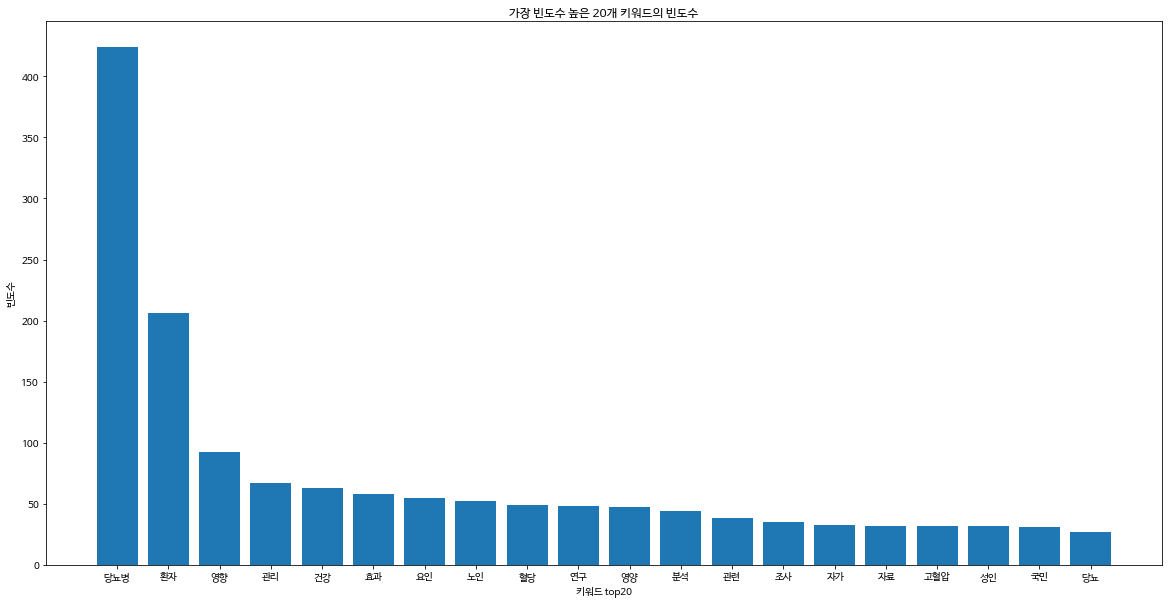

In [15]:
# 가장 빈도수가 높은 20개 키워드를 내림차순 막대그래프로 출력
plt.figure(figsize=(20,10))
plt.bar(word_count_df.index[:20],word_count_df['단어빈도수 합계'][:20])
plt.xlabel('키워드 top20')
plt.ylabel('빈도수')
plt.title('가장 빈도수 높은 20개 키워드의 빈도수')
plt.show()

In [12]:
# 워드 클라우드 생성
from wordcloud import WordCloud
wc = WordCloud(font_path=path, background_color='white')
wc.generate_from_frequencies(word_count_df['단어빈도수 합계'])

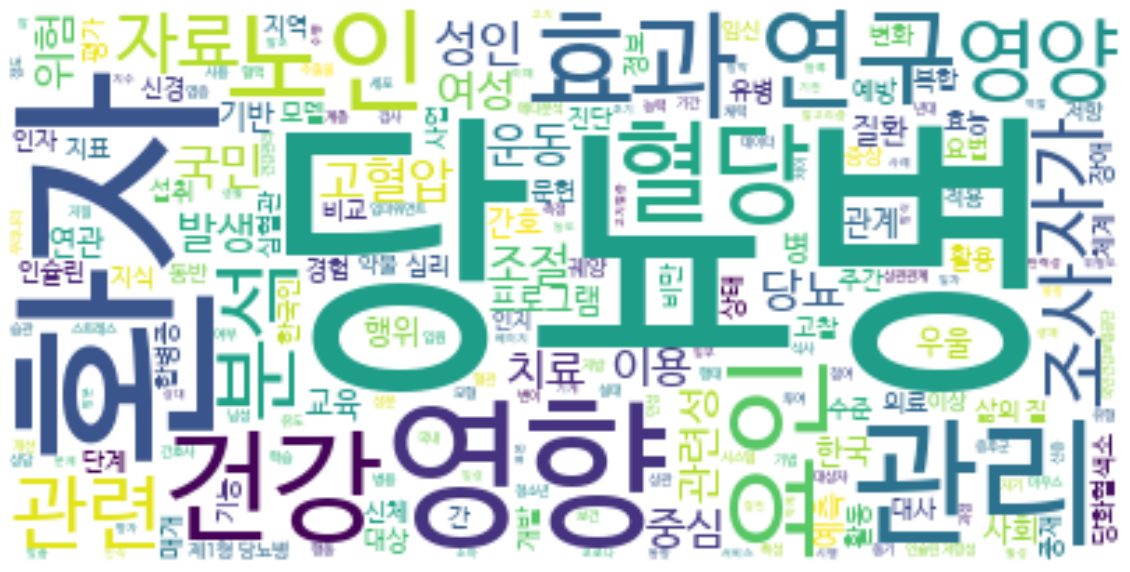

In [14]:
# 생성된 워드 클라우드 이미지를 pyplot을 이용하여 화면에 표시
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# 데이터셋 불러오기

In [89]:
data = pd.read_csv(data_path+'diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# 데이터셋 정보 및 구조 확인

In [23]:
# 누락된 데이터는 없는지 확인
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [24]:
# 데이터 형태 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# 데이터 기초 통계 시각화

In [90]:
# Outcome이 0인 것과 1인 것의 개수
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


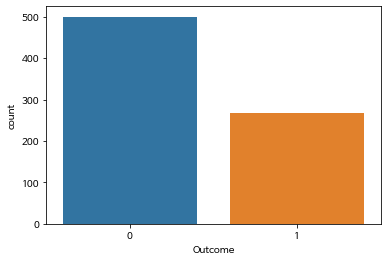

In [26]:
# 데이터 개수 출력하는 그래프를 그려주는 seaborn 패키지 내 countplot() 메소드를 이용해 'Outcome' 개수 확인
# Outcome 1이면 당뇨병, 0이면 정상
sns.countplot(data['Outcome'])

In [27]:
# 각 특성별 상관도 확인
data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


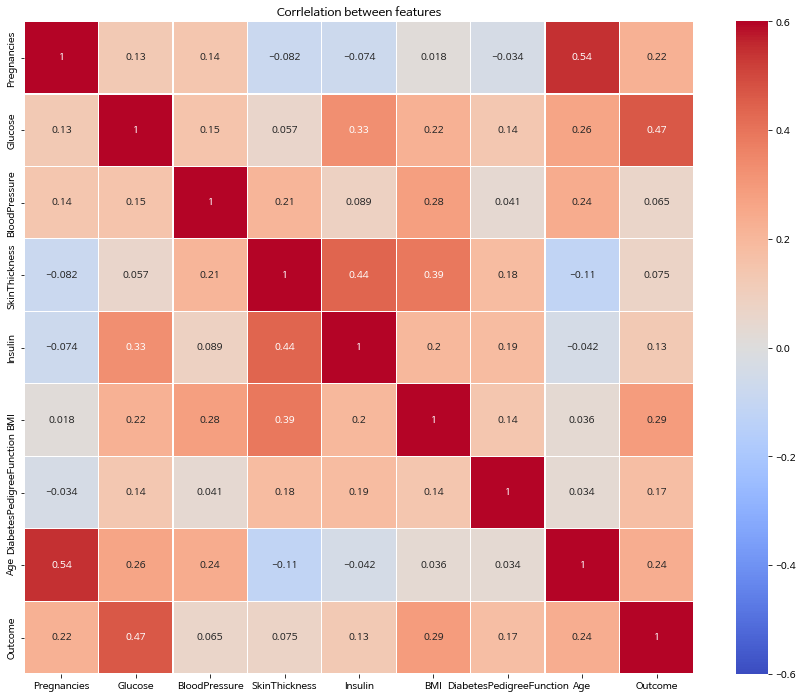

In [28]:
colormap = plt.cm.gist_heat # 그래프 색상
plt.figure(figsize=(15,12)) # 그래프 크기
# 상관계수가 어떻게 되어 있는지 명확히 보기 위해 seaborn 모듈의 heatmap 함수 사용
# 상관계수 양이면 빨간색, 음이면 파란색, 높을 수록 진하기 높게 설정
sns.heatmap(data.corr(), linewidths=0.1, vmin=-0.6, vmax=0.6, cmap='coolwarm', linecolor='white', annot=True)
plt.title('Corrlelation between features')
plt.show()

=> 예측하고자 하는 종속변수인 'Outcome'과 상관관계가 가장 높은 변수는 'Glucose'이며, 그 다음은 'BMI', 'Age' 순이다.

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


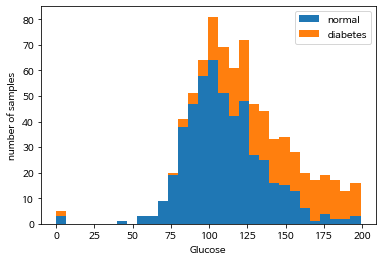

In [29]:
# Glucose가 당뇨병 여부와 어느정도 상관관계가 있는지 시각적으로 보기 위해 히스토그램으로 시각화
plt.hist(x=[data.Glucose[data.Outcome==0], data.Glucose[data.Outcome==1]],
         bins=30, histtype='barstacked', label=['normal','diabetes'])
plt.xlabel('Glucose')
plt.ylabel('number of samples')

plt.legend()

=> Glucose 수치가 높을 수록 당뇨병 비율이 높아지는 것을 시각적으로 확인할 수 있다.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seab

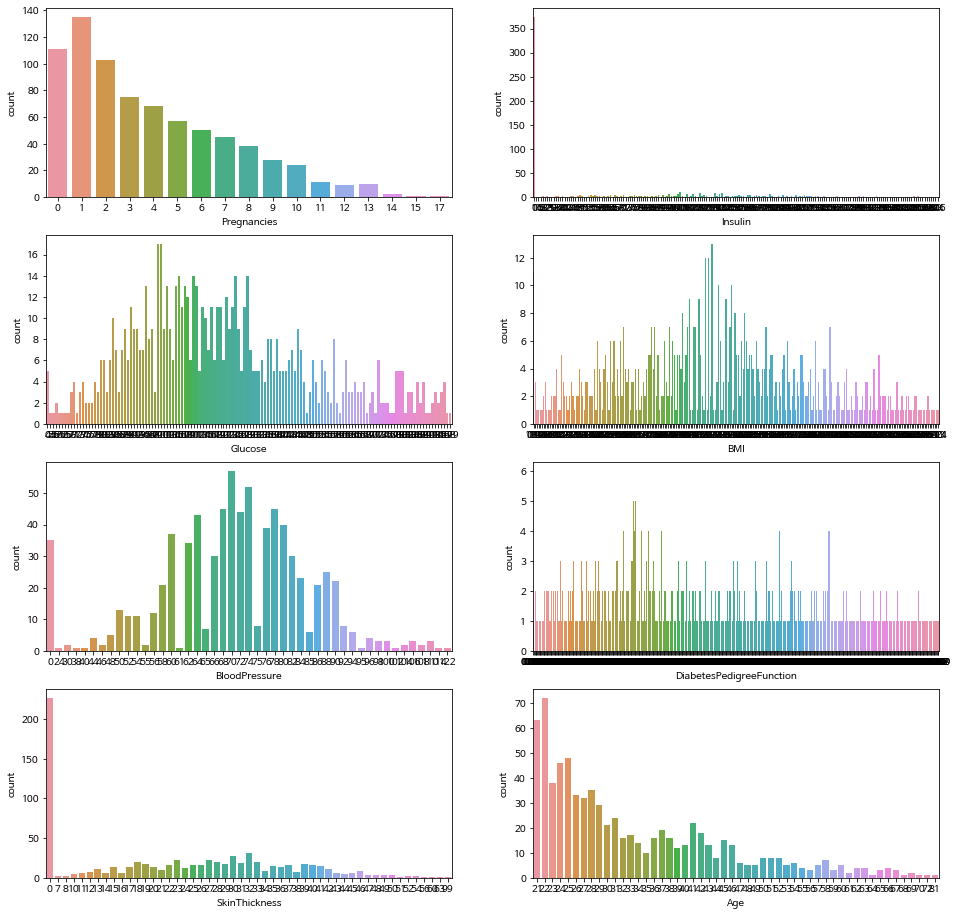

In [30]:
fig, ax = plt.subplots(4,2, figsize=(16,16))
cols = data.columns[:-1] # 종속변수인 Outcome 컬럼을 제외한 모든 컬럼 리스트
for i in range(len(cols)):
    if i < 4:
        sns.countplot(data[cols[i]], ax=ax[i,0])
    else:
        sns.countplot(data[cols[i]], ax=ax[i-4,1])

# 아웃라이어 처리

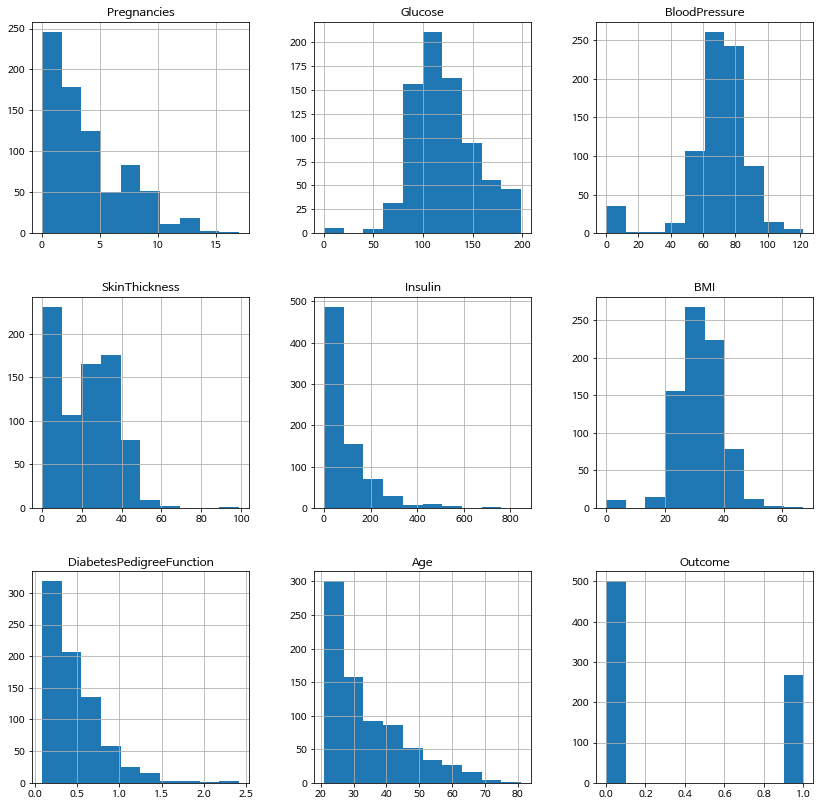

In [31]:
# 전체 변수 대략적인 분포 확인
data.hist(figsize=(14,14))
plt.show()

In [32]:
# 각 특성들의 수치 요약 정보 확인
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 상한 아웃라이어 처리

이상치 판정 방법으로 Box-plot 이상치 판정 방식 사용
-> [Q3+1.5*IQR]보다 큰 데이터는 이상치로 처리

In [92]:
# 각 특성별 위의 아웃라이어 조건에 해당하는 값들의 개수 출력, 아웃라이어 제거
IQR = data.describe().loc['75%'] - data.describe().loc['25%']
threshold = data.describe().loc['75%'] + 1.5 * IQR  # Q3+1.5*IQR

i = 0
for col in data.columns[:-1]:
    n_outlier = np.sum(data[col] > threshold[i])
    print(col, "=> num of outlier : "+str(n_outlier))
    i += 1

Pregnancies => num of outlier : 4
Glucose => num of outlier : 0
BloodPressure => num of outlier : 7
SkinThickness => num of outlier : 1
Insulin => num of outlier : 34
BMI => num of outlier : 8
DiabetesPedigreeFunction => num of outlier : 29
Age => num of outlier : 9


이상치가 너무 많아 데이터 손실이 클 것으로 예상된다.  
다른 이상치 판정 방법을 사용해본다.

이상치 판정 방법으로 3-sigma 이상치 판정 방식 사용
-> [평균 + 3 * 표준편차] 보다 큰 데이터는 이상치로 처리

In [93]:
# 각 특성별 위의 아웃라이어 조건에 해당하는 값들의 개수 출력, 아웃라이어 제거
before_drop = data.shape # 처리 전 데이터 수
for col in data.columns[:-1]:
    mean = data[col].mean()
    std = data[col].std()
    threshold = mean + 3 * std
    n_outlier = np.sum(data[col] > threshold)
    print(col, "=> num of outlier : "+str(n_outlier))
    data.drop(data[data[col] > threshold].index[:], inplace=True)
data.dropna()
after_drop = data.shape # 처리 후 데이터 수

print()
print(f'before drop outlier: {before_drop}')
print(f'after drop outlier: {after_drop}')

Pregnancies => num of outlier : 4
Glucose => num of outlier : 0
BloodPressure => num of outlier : 0
SkinThickness => num of outlier : 1
Insulin => num of outlier : 18
BMI => num of outlier : 3
DiabetesPedigreeFunction => num of outlier : 10
Age => num of outlier : 5

before drop outlier: (768, 9)
after drop outlier: (727, 9)


3-sigma 방식으로 아웃라이어를 처리하자 768개에서 727개로 적당히 줄어들었다. 

###하한 아웃라이어 처리

각 특성들에 대한 그래프 분포와 describe()를 통해 출력된 최소 값들을 보면, 0이면 안되는데 0인 데이터가 꽤 보인다.
예를 들면, Glucose, Bloodpressure, SkinThickness, Insulin, BMI는 생리학적으로 0이라는 수치가 나올 수 없다.
따라서 이 데이터들은 아웃라이어로 간주한다.   
위에서 3-sigma 방식으로 하한 아웃라이어를 처리하지 않은 이유는 모든 0값을 제거하기엔 너무 갯수가 많아 데이터 손실이 커지기 때문이다. 따라서 하한 아웃라이어에 해당하는 0값은 평균값으로 대체하기로 한다.

In [94]:
# 0값이 있는 특성들에서 0값의 데이터 개수와 퍼센트 계산
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI'] # 0이 나올 수 없는 특성들
# 전체 데이터 건수
total_count = data['Glucose'].count()
# 각 특성별로 반복 하면서 값이 0 인 데이터 개수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = data[data[feature] == 0][feature].count()
    print('{0} 0값 개수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0값 개수는 5, 퍼센트는 0.69 %
BloodPressure 0값 개수는 34, 퍼센트는 4.68 %
SkinThickness 0값 개수는 221, 퍼센트는 30.40 %
Insulin 0값 개수는 362, 퍼센트는 49.79 %
BMI 0값 개수는 9, 퍼센트는 1.24 %


In [95]:
# 0값을 평균값으로 대체
data[zero_features]=data[zero_features].replace(0, data[zero_features].mean())

# 스케일링

In [96]:
X = data.drop(columns = 'Outcome', axis=1) # 결과값인 Outcome 컬럼만 삭제하여 X에 대입
y = data.Outcome # 결과값인 Outcome 컬럼만 y에 대입

In [97]:
scaler = StandardScaler()
scaler.fit(X) # fitting
scaled_data = scaler.transform(X)
print(scaled_data)

[[ 0.6631668   0.94209455 -0.01240055 ...  0.20893215  0.64645483
   1.52274953]
 [-0.85772362 -1.18044254 -0.51105401 ... -0.84979392 -0.34728951
  -0.16508061]
 [ 1.27152296  2.12128183 -0.67727182 ... -1.34890763  0.80847837
  -0.07624745]
 ...
 [ 0.35898871  0.0324358  -0.01240055 ... -0.91029255 -0.72894494
  -0.25391378]
 [-0.85772362  0.20089112 -1.00970746 ... -0.32043088 -0.35449055
   1.25625003]
 [-0.85772362 -0.91091402 -0.17861837 ... -0.27505691 -0.47690834
  -0.87574594]]


In [98]:
X = scaled_data # X를 스케일링된 데이터로 갱신
y = data.Outcome

# train set과 test set 분리

In [99]:
'''
<옵션>
- test_size : test set과 train set의 비율 (ex. test_size=0.2는 train set과 test set을 8:2로 나누었음을 의미)
- stratify : y값의 분포를 고려해서 데이터 셋을 나눠준다.
- random_state : 실행할 때마다 같은 숫자가 나오도록 해주는 옵션으로, 아무숫자나 넣어도 된다.
'''
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

# 머신러닝

## SVM(Support Vector Machine)

In [100]:
SVC_model = SVC()
SVC_model.fit(X_train, y_train)

SVC()

In [101]:
SVC_model.score(X_test, y_test)

0.8493150684931506

In [102]:
confusion_matrix(y_test, SVC_model.predict(X_test))

array([[91,  6],
       [16, 33]])

<confusion matrix 구성>    
[TP(당뇨/예측성공), FN(당뇨아님/예측실패)]  
[FP(당뇨/예측실패), TN(당뇨아님/예측성공)]  
   
예측성공 - TP:91개, TN:33개 (총 124개)  
예측실패 - FP:16개, FN:6개 (총 22개)

## Random Forest

In [103]:
# n_estimators : 숲을 만들 때 나무의 개수를 지정하는 옵션으로, 여기서는 100개로 지정
RandomForest_model = RandomForestClassifier(n_estimators=100) 
RandomForest_model.fit(X_train, y_train)

RandomForestClassifier()

In [104]:
RandomForest_model.score(X_test, y_test)

0.815068493150685

In [105]:
confusion_matrix(y_test, RandomForest_model.predict(X_test))

array([[86, 11],
       [16, 33]])

예측성공 - TP:85개, TN:32개 (총 124개)  
예측실패 - FP:17개, FN:12개 (총 22개)

# Data process (SMOTE)

In [106]:
# SMOTE 적용 전 데이터 셋 상태
data['Outcome'].value_counts()

0    481
1    246
Name: Outcome, dtype: int64

In [107]:
oversample = SMOTE()

In [108]:
X, y = oversample.fit_resample(X,y)

In [110]:
X.shape

(962, 8)

In [111]:
y.shape

(962,)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

In [133]:
# 샘플의 수를 늘린 후 다시 SVM으로 머신러닝
SVC_model = SVC()
SVC_model.fit(X_train, y_train)
SVC_model.score(X_test, y_test)

0.8082901554404145

In [134]:
# 샘플의 수를 늘린 후 다시 RandomForest로 머신러닝
RandomForest_model = RandomForestClassifier(n_estimators=100)
RandomForest_model.fit(X_train, y_train)
RandomForest_model.score(X_test, y_test)

0.8601036269430051